# Porting an analysis from local to distributed

In this pair of notebooks, we will develop a prototype unsupervised analysis with sklearn and then port it to use Spark, as we might in real life.

<a href = "http://yogen.io"><img src="http://yogen.io/assets/logo.svg" alt="yogen" style="width: 200px; float: right;"/></a>


## K-means clustering using sklearn

Our starting point is a dataset, `~/Data/airline_tickets/sales_segments.csv.gz`, which contains data for air reservations at segment level.

For each reservation, we get among others a `revenue_amount_seg` value, a `fuel_surcharge_amount_seg` value and a `bookings_seg` value. The first one represents the main amount paid to the airline and the second is referred to as 'tax', but reflects a different kind of revenue that in principle should be roughly proportional to the first kind. The third is the number of persons booked for the segment in question.

The rationale here is that the business side has detected that some of the segments are probably wrong and requested an automated way to detect suspicious segments based on their revenue / fuel_surcharge ratio.

How do you think we could do that in a scalable way?

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

### First, inspect the data 

In [4]:
df = pd.read_csv('sales_segments.csv.gz', sep='^')

/home/dani/anaconda3/envs/master-p3/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2785: DtypeWarning: Columns (40,44,45,47,48,57) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [5]:
df.head()

,rloc,departure_date_seg,booking_date,freq_flyer_flag,creator_office_id,creator_iata_number,creator_gds_code,creator_city_code,creator_lat,creator_lon,...,bookings_seg,rpk_seg,revenue_amount_seg,currency_code,fuel_surcharge_amount_seg,fuel_surcharge_currency_code,emd_count,emd_amount,emd_currency_code,total_outliers
0,59GS9Y,2013-12-21,2013-09-05,False,RUNHS3103,66200201.0,1A,RUN,-20.90083,55.53715,...,1,239,33.56,EUR,7.30,EUR,0,0.0,NaN,7.300000
1,4D87YU,2013-12-29,2013-01-29,False,RUNUU000B,66490104.0,UU,RUN,-20.90083,55.53715,...,5,1116,306.00,EUR,127.50,EUR,0,0.0,NaN,77.271017
2,7W67K8,2013-12-29,2013-02-05,False,RUNUU01A3,66490830.0,UU,RUN,-20.90083,55.53715,...,19,4240,1365.50,EUR,234.00,EUR,0,0.0,NaN,278.175661
3,3ESPWM,2013-12-29,2013-03-19,False,RUNUU010C,66490771.0,UU,RUN,-20.90083,55.53715,...,3,1220,81.35,EUR,39.93,EUR,0,0.0,NaN,32.458243
4,6ITPJM,2013-12-29,2013-05-11,False,MRSA12108,20261721.0,1A,MRS,43.29695,5.38107,...,2,1342,0.00,EUR,31.82,EUR,0,0.0,NaN,32.496507


### Calculate KPIs

* "revenue" per person
* "tax" per person


In [7]:
df['revenue'] = df['revenue_amount_seg'] / df['bookings_seg']
df['tax'] = df['fuel_surcharge_amount_seg'] / df['bookings_seg']

In [9]:
simple = df[['revenue', 'tax']]
simple.head()

,revenue,tax
0,33.560000,7.300000
1,61.200000,25.500000
2,71.868421,12.315789
3,27.116667,13.310000
4,0.000000,15.910000


### Inspect the distributions

In [10]:
simple.describe()

,revenue,tax
count,1.459121e+06,1.459121e+06
mean,2.302315e+02,9.517649e+01
std,3.321169e+03,8.666396e+01
min,0.000000e+00,0.000000e+00
25%,6.400000e+01,1.995000e+01
50%,1.471100e+02,4.400000e+01
75%,2.606250e+02,1.762700e+02
max,1.392156e+06,3.594470e+03


In [11]:
simple.shape

(1459121, 2)

(-50, 600)

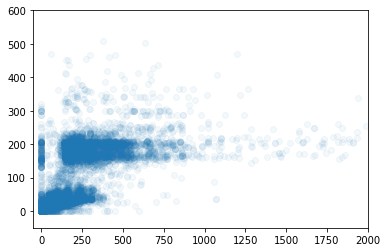

In [38]:
sample = simple.sample(10000, random_state=24) 

f, ax = plt.subplots(1)
ax.scatter(sample['revenue'], sample['tax'], alpha=.05)
ax.set_xlim(-50, 2000)
ax.set_ylim(-50, 600)

## Now for some learning!

It seems there are at least two or three groups of segments.

What we are going to do is to separate them into clusters with kmeans, then use the z-score as an outlier score.

#### Training a model with sklearn is quick and easy

We just use `.fit` and then `.predict`. As we'll see, this is very similar to Spark ML.

In [41]:
from sklearn.cluster import KMeans

model = KMeans(n_clusters=3, random_state=42)

model.fit(simple)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=3, n_init=10, n_jobs=1, precompute_distances='auto',
    random_state=42, tol=0.0001, verbose=0)

In [33]:
model.cluster_centers_

array([[2.08796243e+02, 9.51820421e+01],
       [7.77842455e+05, 3.01670000e+01],
       [1.43154115e+05, 3.34175455e+01]])

In [35]:
model.predict(simple)

array([0, 0, 0, ..., 0, 0, 0], dtype=int32)

In [36]:
simple['cluster'] = model.labels_

/home/dani/anaconda3/envs/master-p3/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [37]:
simple.head()

,revenue,tax,cluster
0,33.560000,7.300000,0
1,61.200000,25.500000,0
2,71.868421,12.315789,0
3,27.116667,13.310000,0
4,0.000000,15.910000,0


It was that easy! now let's see what we got:

### Let's have a look

(-50, 600)

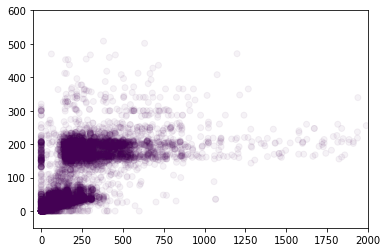

In [39]:
sample = simple.sample(10000, random_state=24) 

f, ax = plt.subplots(1)
ax.scatter(sample['revenue'], sample['tax'], alpha=.05, c=sample['cluster'])
ax.set_xlim(-50, 2000)
ax.set_ylim(-50, 600)

In [40]:
sample['cluster'].value_counts()

0    10000
Name: cluster, dtype: int64

This doesn't look too good... Let's do it with more clusters.

In [42]:
from sklearn.cluster import KMeans

model = KMeans(n_clusters=8, random_state=42)
model.fit(simple)
simple['cluster'] = model.labels_

/home/dani/anaconda3/envs/master-p3/lib/python3.6/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """


In [44]:
simple['cluster'].value_counts()

7    1242615
0     216330
3         95
6         46
2         16
4         10
1          8
5          1
Name: cluster, dtype: int64

(-50, 600)

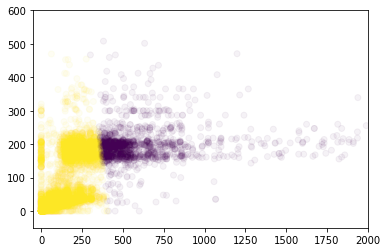

In [45]:
sample = simple.sample(10000, random_state=24) 

f, ax = plt.subplots(1)
ax.scatter(sample['revenue'], sample['tax'], alpha=.05, c=sample['cluster'])
ax.set_xlim(-50, 2000)
ax.set_ylim(-50, 600)

### Z scores

Now we only need to calculate a z-score, so that we can score points as outliers or not outliers.



#### Calculate means and standard deviations in each direction for each cluster

In [46]:
stats = simple.groupby('cluster').agg(['mean', 'std'])
stats

revenue                       tax            
                 mean           std        mean         std
cluster                                                    
0        6.331785e+02    422.204451  195.734153   53.826496
1        6.152070e+05  53170.300072   29.731250    1.542099
2        3.467367e+05  52460.589267  102.778125  112.845184
3        1.122863e+05  22148.322086   21.696947   65.610380
4        8.775004e+05  50236.153381   30.302000    1.808823
5        1.392156e+06           NaN   32.740000         NaN
6        4.391545e+04  12642.971758   33.071603   34.736983
7        1.332965e+02     94.476412   77.678969   79.038928

#### And annotate each point with the stats for its cluster

In [48]:
annotated = simple.join(stats, on='cluster', how='left')

/home/dani/anaconda3/envs/master-p3/lib/python3.6/site-packages/pandas/core/reshape/merge.py:544: UserWarning: merging between different levels can give an unintended result (1 levels on the left, 2 on the right)
  warnings.warn(msg, UserWarning)


In [54]:
annotated.head()

,revenue,tax,cluster,"(revenue, mean)","(revenue, std)","(tax, mean)","(tax, std)",z-score_rev,z-score_tax
0,33.560000,7.300000,7,133.296497,94.476412,77.678969,79.038928,-1.055676,-0.890434
1,61.200000,25.500000,7,133.296497,94.476412,77.678969,79.038928,-0.763116,-0.660168
2,71.868421,12.315789,7,133.296497,94.476412,77.678969,79.038928,-0.650195,-0.826975
3,27.116667,13.310000,7,133.296497,94.476412,77.678969,79.038928,-1.123877,-0.814396
4,0.000000,15.910000,7,133.296497,94.476412,77.678969,79.038928,-1.410897,-0.781501


#### Now we are ready to calculate the z scores

In [55]:
import numpy as np

annotated['z-score_rev'] = (annotated['revenue'] - annotated[('revenue', 'mean')]) / annotated[('revenue', 'std')]
annotated['z-score_tax'] = (annotated['tax'] - annotated[('tax', 'mean')]) / annotated[('tax', 'std')]
annotated['z-score'] = np.sqrt(annotated['z-score_rev'] ** 2 + annotated['z-score_tax'] ** 2)  
annotated.sample(10)

,revenue,tax,cluster,"(revenue, mean)","(revenue, std)","(tax, mean)","(tax, std)",z-score_rev,z-score_tax,z-score
630374,407.000,118.610,0,633.178484,422.204451,195.734153,53.826496,-0.535708,-1.432829,1.529700
986035,74.500,31.110,7,133.296497,94.476412,77.678969,79.038928,-0.622340,-0.589190,0.857002
1351202,244.000,48.560,7,133.296497,94.476412,77.678969,79.038928,1.171758,-0.368413,1.228310
808376,104.440,47.880,7,133.296497,94.476412,77.678969,79.038928,-0.305436,-0.377016,0.485214
24783,111.840,29.110,7,133.296497,94.476412,77.678969,79.038928,-0.227110,-0.614494,0.655120
1320021,262.000,175.660,7,133.296497,94.476412,77.678969,79.038928,1.362282,1.239655,1.841890
146692,453.990,208.620,0,633.178484,422.204451,195.734153,53.826496,-0.424412,0.239396,0.487274
689822,167.715,18.425,7,133.296497,94.476412,77.678969,79.038928,0.364308,-0.749681,0.833512
555527,73.480,44.070,7,133.296497,94.476412,77.678969,79.038928,-0.633137,-0.425220,0.762676
460599,458.690,204.100,0,633.178484,422.204451,195.734153,53.826496,-0.413280,0.155422,0.441538


In [56]:
annotated['outlier'] = annotated['z-score'] > 3
annotated['outlier'].value_counts() 

False    1437603
True       21518
Name: outlier, dtype: int64

### How does this perform as an outlier detection method?

(-50, 600)

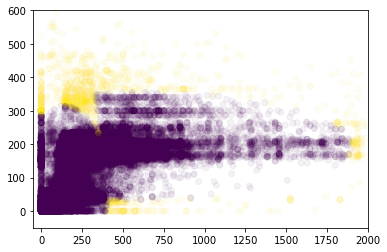

In [58]:
sample = annotated.sample(100000, random_state=24) 

f, ax = plt.subplots(1)
ax.scatter(sample['revenue'], sample['tax'], alpha=.05, c=sample['outlier'])
ax.set_xlim(-50, 2000)
ax.set_ylim(-50, 600)

### Appendix: saving models in sklearn

In [61]:
import joblib

joblib.dump(model, 'mikmeansmodel.pkl')

['mikmeansmodel.pkl']

In [62]:
reconstituted_model = joblib.load('mikmeansmodel.pkl')

In [63]:
reconstituted_model

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=8, n_init=10, n_jobs=1, precompute_distances='auto',
    random_state=42, tol=0.0001, verbose=0)

## OK, let's move this to a more public place: the cluster!